# Loading synthetic Medicare data
1. Beneficiary file
2. Inpatient file
3. Outpatient file

### Importing packages

In [2]:
%matplotlib inline
import sys
print(sys.version)
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
1.16.4
0.24.2


### Beneficiary file

#### Variables:
- SP_* are chronic condition flags (see assumptions section)
- Total costs (MEDREIMB + BENRES + PPPYMT):
    - MEDREIMB_\*: total annual costs for inpatient/outpatient/carrier
    - BENRES_\*: out of pocket costs for inpatient/outpatient/carrier
    - PPPYMT_\*: primary payer reimbursement amount inpatient/outpatient/carrier (in case other primary insurance)


#### Assumptions:
- We treat the chronic condition flags as accurate, despire there possibly being some discrepenacies due to order of processing claims versus when flag was calculated. 
- We decided not to look at carrier claims, but these contain some really good information. Perhas not required beyond calculating cost of care, but let's discuss. 
- We decide to include individuals with full coverage in a given year. 

#### Step 1: load data from csv and append all years of beneficiary file into one single data frame

In [3]:
#no need of following variables: 
#BENE_HMO_CVRAGE_TOT_MONS (HMO coverage)
#PLAN_CVRG_MOS_NUM (Part D coverage)

#I will optimize this later on. I know it's ugly!
beneficiary_2008 = pd.read_csv("DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv")
beneficiary_2008['YEAR'] = 2008
del beneficiary_2008['BENE_HMO_CVRAGE_TOT_MONS']
del beneficiary_2008['PLAN_CVRG_MOS_NUM']

beneficiary_2009 = pd.read_csv("DE1_0_2009_Beneficiary_Summary_File_Sample_1.csv")
beneficiary_2009['YEAR'] = 2009
del beneficiary_2009['BENE_HMO_CVRAGE_TOT_MONS']
del beneficiary_2009['PLAN_CVRG_MOS_NUM']

beneficiary_2010 = pd.read_csv("DE1_0_2010_Beneficiary_Summary_File_Sample_1.csv")
beneficiary_2010['YEAR'] = 2010
del beneficiary_2010['BENE_HMO_CVRAGE_TOT_MONS']
del beneficiary_2010['PLAN_CVRG_MOS_NUM']

frames = [beneficiary_2008, beneficiary_2009, beneficiary_2010]
beneficiary = pd.concat(frames, sort = False)

print(beneficiary.shape)
beneficiary.dtypes

(343644, 31)


DESYNPUF_ID                  object
BENE_BIRTH_DT                 int64
BENE_DEATH_DT               float64
BENE_SEX_IDENT_CD             int64
BENE_RACE_CD                  int64
BENE_ESRD_IND                object
SP_STATE_CODE                 int64
BENE_COUNTY_CD                int64
BENE_HI_CVRAGE_TOT_MONS       int64
BENE_SMI_CVRAGE_TOT_MONS      int64
SP_ALZHDMTA                   int64
SP_CHF                        int64
SP_CHRNKIDN                   int64
SP_CNCR                       int64
SP_COPD                       int64
SP_DEPRESSN                   int64
SP_DIABETES                   int64
SP_ISCHMCHT                   int64
SP_OSTEOPRS                   int64
SP_RA_OA                      int64
SP_STRKETIA                   int64
MEDREIMB_IP                 float64
BENRES_IP                   float64
PPPYMT_IP                   float64
MEDREIMB_OP                 float64
BENRES_OP                   float64
PPPYMT_OP                   float64
MEDREIMB_CAR                

### Step 2: Selecting eligible individuals


Text(0.5, 0, 'Months')

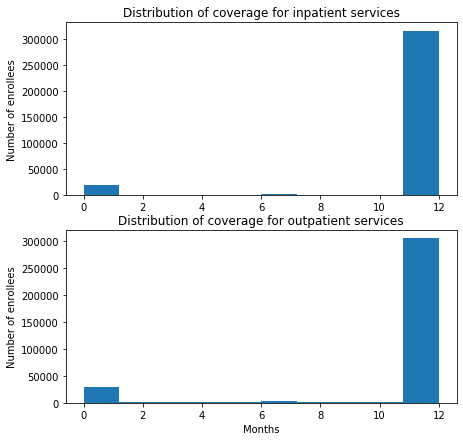

In [4]:
#Let us first look at coverage
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(beneficiary.BENE_HI_CVRAGE_TOT_MONS)
ax1.set_title('Distribution of coverage for inpatient services')
ax1.set_ylabel('Number of enrollees')
ax2.hist(beneficiary.BENE_SMI_CVRAGE_TOT_MONS)
ax2.set_title('Distribution of coverage for outpatient services')
ax2.set_ylabel('Number of enrollees')
ax2.set_xlabel('Months')

In [5]:
beneficiary.BENE_DEATH_DT.isnull().values.any()
beneficiary.BENE_DEATH_DT.fillna(0, inplace=True)
beneficiary.BENE_DEATH_DT.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: BENE_DEATH_DT, dtype: float64

In [6]:
#Based on the plots above, we see that the distribution of months of enrollment is very skewed.
#Most people are enrolled for more than 12 months. 

#Creating a death flag
beneficiary['DEATH'] = np.where(beneficiary['BENE_DEATH_DT']>0,1,0)
print('The total number of diseased is:', beneficiary.DEATH.sum())

beneficiary['SP_ALL'] = np.where((beneficiary['SP_ALZHDMTA']>0)
                                 |(beneficiary['SP_CHF']>0 )
                                 |(beneficiary['SP_CHRNKIDN']>0)
                                 |(beneficiary['SP_CNCR']>0)
                                 |(beneficiary['SP_COPD']>0)
                                 |(beneficiary['SP_DEPRESSN']>0)
                                 |(beneficiary['SP_DIABETES']>0)
                                 |(beneficiary['SP_ISCHMCHT']>0)
                                 |(beneficiary['SP_OSTEOPRS']>0)
                                 |(beneficiary['SP_RA_OA']>0)
                                 |(beneficiary['SP_STRKETIA']>0)
                                 ,1,0)

#Creating a chronic dx flag:

#Creating crosstabs to look at the relationship between being dead and having full eligibility.
print(pd.crosstab(beneficiary.DEATH, beneficiary.BENE_HI_CVRAGE_TOT_MONS))
print("The correlation between being diseased and having some coverage is: ", beneficiary.DEATH.corr(beneficiary.BENE_SMI_CVRAGE_TOT_MONS))
print(pd.crosstab(beneficiary.DEATH, beneficiary.SP_ALL))
# For this, we could clean these variables and look at correlations. 

The total number of diseased is: 5461
BENE_HI_CVRAGE_TOT_MONS     0    1    2    3    4    5    6    7    8     9   \
DEATH                                                                          
0                        18547  689  590  653  717  825  876  931  991  1145   
1                          307    7   10    7    8   11   19   16   19    21   

BENE_HI_CVRAGE_TOT_MONS    10    11      12  
DEATH                                        
0                        1287  1508  309424  
1                          15    19    5002  
The correlation between being diseased and having some coverage is:  -0.00023801238867062475
SP_ALL       1
DEATH         
0       338183
1         5461


In [7]:
# Selected a cohort of diseased individuals, with full eligibility. 
beneficiary_full = pd.DataFrame(beneficiary[(beneficiary.BENE_HI_CVRAGE_TOT_MONS == 12) & (beneficiary.BENE_SMI_CVRAGE_TOT_MONS == 12) & (beneficiary.DEATH ==1)])
print(beneficiary_full.shape)

(4730, 33)


In [8]:
#Creating cost variables
beneficiary_full['TOTAL_COST_IP'] = beneficiary_full['MEDREIMB_IP'] + beneficiary_full['BENRES_IP'] + beneficiary_full['PPPYMT_IP']
beneficiary_full['TOTAL_COST_OP'] = beneficiary_full['MEDREIMB_OP'] + beneficiary_full['BENRES_OP'] + beneficiary_full['PPPYMT_OP']
beneficiary_full['TOTAL_COST_CAR'] = beneficiary_full['MEDREIMB_CAR'] + beneficiary_full['BENRES_CAR'] + beneficiary_full['PPPYMT_CAR']
beneficiary_full['TOTAL_COST'] = beneficiary_full['TOTAL_COST_IP'] + beneficiary_full['TOTAL_COST_OP'] + beneficiary_full['TOTAL_COST_CAR']
beneficiary_full.head()


,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,YEAR,DEATH,SP_ALL,TOTAL_COST_IP,TOTAL_COST_OP,TOTAL_COST_CAR,TOTAL_COST
118,0033C90574583C0D,19360801,20080901.0,2,1,0,49,770,12,12,...,860.0,290.0,0.0,2008,1,1,0.0,0.0,1150.0,1150.0
165,00521D781532612C,19370801,20080701.0,2,1,0,51,160,12,12,...,470.0,60.0,0.0,2008,1,1,0.0,640.0,530.0,1170.0
200,00653DC86A0E30D8,19490601,20080501.0,1,3,0,33,610,12,12,...,0.0,0.0,0.0,2008,1,1,0.0,0.0,0.0,0.0
214,006D438FFACFB5FD,19200601,20080101.0,2,2,0,5,470,12,12,...,0.0,0.0,0.0,2008,1,1,0.0,0.0,0.0,0.0
253,0083EA0267C0F7CA,19351201,20080201.0,1,1,0,33,331,12,12,...,0.0,0.0,0.0,2008,1,1,0.0,0.0,0.0,0.0


In [9]:
print(beneficiary_full['TOTAL_COST_IP'].describe())
print(beneficiary_full['TOTAL_COST_OP'].describe())
print(beneficiary_full['TOTAL_COST_CAR'].describe())

count      4730.000000
mean       1249.919239
std        6174.237967
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      136296.000000
Name: TOTAL_COST_IP, dtype: float64
count     4730.000000
mean       460.890063
std       1759.175358
min        -30.000000
25%          0.000000
50%          0.000000
75%        260.000000
max      61650.000000
Name: TOTAL_COST_OP, dtype: float64
count     4730.000000
mean       774.794926
std       1177.773278
min          0.000000
25%          0.000000
50%        300.000000
75%       1100.000000
max      17070.000000
Name: TOTAL_COST_CAR, dtype: float64


Text(0.5, 1.0, 'Other insurance inpatient costs')

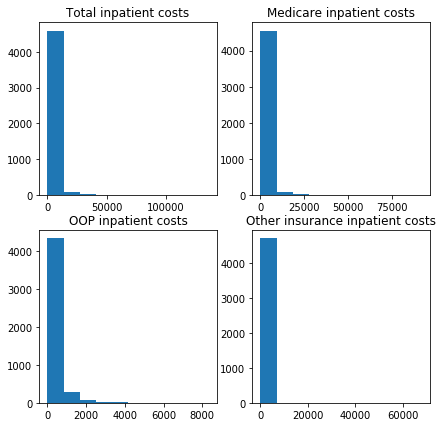

In [10]:
#calculate full costs
#beneficiary_full['TOTAL_COST_IP'] = beneficiary_full['MEDREIMB_IP'] + beneficiary_full['BENRES_IP'] + beneficiary_full['PPPYMT_IP']

fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.hist(beneficiary_full.TOTAL_COST_IP)
ax1.set_title('Total inpatient costs')
ax2.hist(beneficiary_full.MEDREIMB_IP)
ax2.set_title('Medicare inpatient costs')
ax3.hist(beneficiary_full.BENRES_IP)
ax3.set_title('OOP inpatient costs')
ax4.hist(beneficiary_full.PPPYMT_IP)
ax4.set_title('Other insurance inpatient costs')

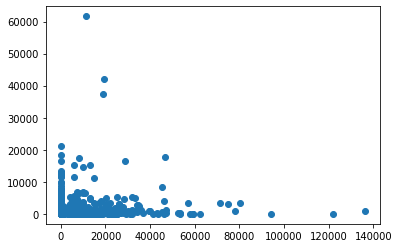

In [11]:
plt.scatter(beneficiary_full.TOTAL_COST_IP,beneficiary_full.TOTAL_COST_OP)

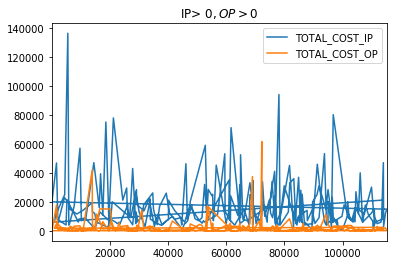

In [12]:
beneficiary_full.loc[(beneficiary_full.TOTAL_COST_IP > 0) & (beneficiary_full.TOTAL_COST_OP > 0), ['TOTAL_COST_IP','TOTAL_COST_OP']].plot(title='IP> $0, OP >$0')



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ebc4630>,
      dtype=object)

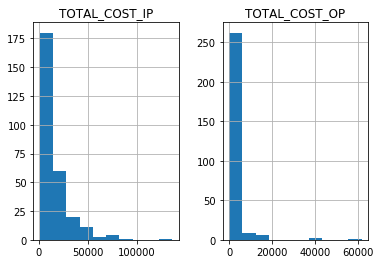

In [14]:
beneficiary_full.loc[(beneficiary_full.TOTAL_COST_IP > 0) & (beneficiary_full.TOTAL_COST_OP > 0), ['TOTAL_COST_IP','TOTAL_COST_OP']].hist()
